# ML Foreclosure Binary Classification - EPOCH 2 data

    target = zeroBalCode (set to object dtype) 
    Binary classification sets zeroBalCode to either "0" or "1" for the 7 possible outcomes
    
    "0" = "Loan Success"
        * 01 = Prepaid or Matured

    "1" =  "Loan Failure" - Most likely loss of money (but not necessarily) one of below conditions:
        * 02 = Third Party Sale
        * 03 = Short Sale
        * 06 = Repurchased
        * 09 = Deed-in-Lieu,REO
        * 15 = Note Sale
        * 16 = Reperforming Loan Sale

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip install pycaret
from imblearn.over_sampling import RandomOverSampler
from pycaret.classification import *
#from pycaret.regression import *

Using TensorFlow backend.


# Importing the data - only use *.ML.csv files!!!
If you have *.MLReady.csv then [click here](#MLReady)

In [32]:
df=pd.read_csv("D:\FM_Acq_Perf_FMAC_EPOCH2_ML.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,id,origChannel,origIntRate,origUPB,origDate,firstPmtDate,origLTV,numBorrowers,...,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct
0,1133339,1133339,100209956357,2,5.125,348000,2009-02-01,2009-04-01,87.0,1.0,...,5.04,5.13,0.041667,2.87,-0.125,-0.085,-0.005,-0.023810,-0.016865,-0.000975
1,1133340,1133340,100392775700,3,4.625,195000,2009-02-01,2009-04-01,52.0,2.0,...,5.04,5.13,0.041667,2.87,-0.625,0.415,-0.505,-0.119048,0.082341,-0.098441
2,1133341,1133341,100621428854,2,4.875,342000,2009-02-01,2009-04-01,80.0,1.0,...,5.04,5.13,0.041667,2.87,-0.375,0.165,-0.255,-0.071429,0.032738,-0.049708
3,1133342,1133342,100720959726,1,5.375,93000,2009-02-01,2009-05-01,70.0,1.0,...,5.04,5.13,0.041667,2.87,0.125,-0.335,0.245,0.023810,-0.066468,0.047758
4,1133343,1133343,100783704799,1,4.875,182000,2009-02-01,2009-04-01,76.0,2.0,...,5.04,5.13,0.041667,2.87,-0.375,0.165,-0.255,-0.071429,0.032738,-0.049708


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119696 entries, 0 to 119695
Data columns (total 60 columns):
Unnamed: 0                    119696 non-null int64
Unnamed: 0.1                  119696 non-null int64
id                            119696 non-null int64
origChannel                   119696 non-null int64
origIntRate                   119696 non-null float64
origUPB                       119696 non-null int64
origDate                      119696 non-null object
firstPmtDate                  119696 non-null object
origLTV                       119696 non-null float64
numBorrowers                  119696 non-null float64
origDebtIncRatio              119696 non-null float64
borrCreditScore               119696 non-null float64
loanPurp                      119696 non-null int64
zipCode                       119696 non-null int64
pMIperct                      119696 non-null float64
mortInsType                   119696 non-null float64
bestCreditScore               119696 non-

## Remove columns not involved in 'Foreclosure or Not' query

In [34]:
df.drop(['Unnamed: 0','Unnamed: 0.1','id','firstPmtDate','rptPeriod','currIntRate','currUPB','loanAge','monMatur',\
         'zeroBalDate','lastPdInstDate','forecloDate','dispDate','forecloCost','propRepCost','recovCosts',\
         'miscCost','holdTaxCost','saleProceed','credEnhProceed','repurchProceed','otherForecloProceed',\
         'nonIntUPB','prinForgivBal','repurchMakeWholeProceedFlg','forecloPrinWriteOffAmnt','servActivIndicator',\
         'deliqGood','deliqBad','deliqMax'],1,inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119696 entries, 0 to 119695
Data columns (total 30 columns):
origChannel           119696 non-null int64
origIntRate           119696 non-null float64
origUPB               119696 non-null int64
origDate              119696 non-null object
origLTV               119696 non-null float64
numBorrowers          119696 non-null float64
origDebtIncRatio      119696 non-null float64
borrCreditScore       119696 non-null float64
loanPurp              119696 non-null int64
zipCode               119696 non-null int64
pMIperct              119696 non-null float64
mortInsType           119696 non-null float64
bestCreditScore       119696 non-null float64
worstCreditScore      119696 non-null float64
avgCreditScore        119696 non-null float64
bankNumber            119696 non-null int64
stateNumber           119696 non-null int64
mSA                   119696 non-null int64
zeroBalCode           119696 non-null float64
fmacRateMax           119696 n

## Engineer originDate into Date features

In [36]:
df['origDate'] = pd.to_datetime(df['origDate'])

In [37]:
df['origYear'] = df['origDate'].dt.year
df['origMonth'] = df['origDate'].dt.month

In [38]:
df.drop(['origDate'],1,inplace=True)

In [39]:
df[['origYear','origMonth']].head()

,origYear,origMonth
0,2009,2
1,2009,2
2,2009,2
3,2009,2
4,2009,2


# Turn zero Balance Code Into binary "0" GOOD and "1" BAD

In [40]:
df.zeroBalCode.unique()

array([ 9.,  1.,  3., 16.,  6.,  2., 15.])

In [41]:
df['zeroBalCode'] = df.zeroBalCode.replace(1,0)
df['zeroBalCode'] = df.zeroBalCode.replace([9,3,16,6,2,15],1)

In [42]:
df.zeroBalCode.unique()

array([1., 0.])

In [43]:
df.zeroBalCode.value_counts()

0.0    103388
1.0     16308
Name: zeroBalCode, dtype: int64

In [44]:
good = df.zeroBalCode.value_counts()[0]
bad = df.zeroBalCode.value_counts()[1]
perct_bad = round(good/bad,2)
print(f'We have {perct_bad}% Foreclosures in our dataset')

We have 6.34% Foreclosures in our dataset


In [45]:
#Checking datatypes of individual feature
#df.info()

# Review values for dates and slice (if needed) the timeframe you want

In [46]:
df.origYear.unique()

array([2009, 2010, 2011, 2012, 2013], dtype=int64)

In [47]:
df['origMonth'].unique()

array([ 2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12,  1], dtype=int64)

# Coerce the column dtype (int in this case)

In [48]:
df = df.astype({'origLTV':'int','numBorrowers':'int','origDebtIncRatio':'int',\
               'borrCreditScore':'int','mortInsType':'int','bestCreditScore':'int',\
               'worstCreditScore':'int','avgCreditScore':'int','zeroBalCode':'int'})
#,'zeroBalCode':'int'

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119696 entries, 0 to 119695
Data columns (total 31 columns):
origChannel           119696 non-null int64
origIntRate           119696 non-null float64
origUPB               119696 non-null int64
origLTV               119696 non-null int32
numBorrowers          119696 non-null int32
origDebtIncRatio      119696 non-null int32
borrCreditScore       119696 non-null int32
loanPurp              119696 non-null int64
zipCode               119696 non-null int64
pMIperct              119696 non-null float64
mortInsType           119696 non-null int32
bestCreditScore       119696 non-null int32
worstCreditScore      119696 non-null int32
avgCreditScore        119696 non-null int32
bankNumber            119696 non-null int64
stateNumber           119696 non-null int64
mSA                   119696 non-null int64
zeroBalCode           119696 non-null int32
fmacRateMax           119696 non-null float64
fmacRateMin           119696 non-null float64
f

<a id='MLReady'></a>

<a id='MLReady'></a>
## *MLReady.csv file loading point
uncomment one of the boxes below

In [50]:
#df.to_csv('D:\FM_FULL_EPOCH2_MLReady.csv')

In [51]:
#df = pd.read_csv('D:\FM_FULL_EPOCH2_MLReady.csv')

# Oversampling (Since we are starting with only 6.3% of our predicted class)

In [52]:
# First, let's split our data into X and y:
X = df.loc[:, df.columns != 'zeroBalCode']
y = df['zeroBalCode']

rows, cols = X.shape
print(f'There are currently {cols} features and {rows} rows')
print(type(X))

There are currently 30 features and 119696 rows
<class 'pandas.core.frame.DataFrame'>


In [53]:
# https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py
# sampling_strategy='minority'
# sampling_strategy=0.5
ros = RandomOverSampler(sampling_strategy='minority')
X_res, y_res = ros.fit_resample(X, y)

In [54]:
print('#############################################')
print('Before oversampling: "Closed" crushes "Default" and causes issues:')
print(y.value_counts())
print('')
print('Before oversampling: "Closed" and "Default" are equal')
print(y_res.value_counts())

#############################################
Before oversampling: "Closed" crushes "Default" and causes issues:
0    103388
1     16308
Name: zeroBalCode, dtype: int64

Before oversampling: "Closed" and "Default" are equal
1    103388
0    103388
Name: zeroBalCode, dtype: int64


## Recombine X_res, y_res so PyCaret can deal with one dataframe input

In [55]:
y_res.shape

(206776,)

In [56]:
df = X_res.copy()

In [57]:
df['zeroBalCode'] = y_res

In [58]:
df.shape

(206776, 31)

# Review metrics last time before run (to have record of starting values)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206776 entries, 0 to 206775
Data columns (total 31 columns):
origChannel           206776 non-null int64
origIntRate           206776 non-null float64
origUPB               206776 non-null int64
origLTV               206776 non-null int32
numBorrowers          206776 non-null int32
origDebtIncRatio      206776 non-null int32
borrCreditScore       206776 non-null int32
loanPurp              206776 non-null int64
zipCode               206776 non-null int64
pMIperct              206776 non-null float64
mortInsType           206776 non-null int32
bestCreditScore       206776 non-null int32
worstCreditScore      206776 non-null int32
avgCreditScore        206776 non-null int32
bankNumber            206776 non-null int64
stateNumber           206776 non-null int64
mSA                   206776 non-null int64
fmacRateMax           206776 non-null float64
fmacRateMin           206776 non-null float64
fmacRateAvg           206776 non-null float64

In [60]:
df.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,borrCreditScore,loanPurp,zipCode,pMIperct,...,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,origYear,origMonth,zeroBalCode
0,2,5.125,348000,87,1,50,689,2,51,25.0,...,2.87,-0.125,-0.085,-0.005,-0.023810,-0.016865,-0.000975,2009,2,1
1,3,4.625,195000,52,2,54,703,1,82,0.0,...,2.87,-0.625,0.415,-0.505,-0.119048,0.082341,-0.098441,2009,2,0
2,2,4.875,342000,80,1,54,746,1,981,0.0,...,2.87,-0.375,0.165,-0.255,-0.071429,0.032738,-0.049708,2009,2,0
3,1,5.375,93000,70,1,50,780,1,496,0.0,...,2.87,0.125,-0.335,0.245,0.023810,-0.066468,0.047758,2009,2,1
4,1,4.875,182000,76,2,22,802,1,18,0.0,...,2.87,-0.375,0.165,-0.255,-0.071429,0.032738,-0.049708,2009,2,0


# Pycaret - Setup with categorical definition

### Use setup file from Scott & Justin

In [61]:
model_setup = setup(
    df
    , target = 'zeroBalCode' # PyCaret will list this as "Label"
    , pca = False 
    , ignore_low_variance = True # Variance is calculated using the ratio of unique values to the number of samples, and the ratio of the most common value to the frequency of the second most common value.
    , normalize = True
    , ignore_features = None
    , handle_unknown_categorical = True
    , remove_outliers = True # outliers from the training data are removed using PCA linear dimensionality reduction using the Singular Value Decomposition technique.
    , bin_numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'origDebtIncRatio'
            , 'bestCreditScore'
            , 'avgCreditScore'
            , 'worstCreditScore'
        ] # Set to True to bin numerics using K Means
    , feature_selection = True
    , silent = True
    , profile = False
    , categorical_features = [
            'origChannel'
            , 'numBorrowers'
            , 'loanPurp'
            , 'zipCode'
            , 'bankNumber'
            , 'stateNumber'
            , 'origYear'
            , 'origMonth'
            , 'mSA'
        ]
        , numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'pMIperct'
            , 'origDebtIncRatio'
            , 'bestCreditScore'
            , 'avgCreditScore'
            , 'worstCreditScore'
            , 'rateDiffAbove'
            , 'rateDiffBelow'
            , 'rateDiffAvg'
            , 'rateDiffAbovePct'
            , 'rateDiffBelowPct'
            , 'rateDiffAvgPct'
        ]
)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,883
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(206776, 31)"
4,Missing Values,False
5,Numeric Features,21
6,Categorical Features,9
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## Compare Models with no blacklist exclusions

In [62]:
model_results=compare_models() #blacklist = ['tr','ransac'],'lar','par','huber','llar','lasso','en','ridge','omp','br','svm'])
model_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.9489,0.987,0.9545,0.9438,0.9491,0.8978
1,Random Forest Classifier,0.9191,0.9761,0.9503,0.8943,0.9214,0.8382
2,Decision Tree Classifier,0.8732,0.8734,0.9666,0.8142,0.8839,0.7465
3,CatBoost Classifier,0.766,0.8431,0.8216,0.7389,0.778,0.5321
4,Light Gradient Boosting Machine,0.742,0.8183,0.8012,0.7158,0.7561,0.484
5,Ridge Classifier,0.7343,0,0.7766,0.7154,0.7448,0.4687
6,Linear Discriminant Analysis,0.7343,0.8062,0.7764,0.7155,0.7447,0.4686
7,Logistic Regression,0.734,0.8066,0.7703,0.7175,0.743,0.468
8,SVM - Linear Kernel,0.732,0,0.785,0.7096,0.745,0.4641
9,K Neighbors Classifier,0.7255,0.8019,0.8496,0.6802,0.7555,0.4512


## Create models 

#### Extra Trees Classifier

In [73]:
et = create_model('et', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9523,0.9887,0.9569,0.9480,0.9525,0.9046
1,0.9514,0.9887,0.9600,0.9435,0.9517,0.9028
2,0.9496,0.9863,0.9534,0.9461,0.9497,0.8992
3,0.9490,0.9864,0.9515,0.9466,0.9490,0.8980
4,0.9479,0.9869,0.9498,0.9461,0.9480,0.8959
5,0.9452,0.9843,0.9500,0.9408,0.9454,0.8905
6,0.9470,0.9858,0.9559,0.9391,0.9474,0.8940
7,0.9476,0.9866,0.9540,0.9419,0.9479,0.8953
8,0.9525,0.9876,0.9565,0.9488,0.9526,0.9050
9,0.9462,0.9881,0.9565,0.9370,0.9467,0.8924


#### CatBoost

In [64]:
#catboost =create_model('catboost', fold = 10)

#### XGBoost

In [65]:
#xgboost = create_model('xgboost', fold = 10)

## Tune Models

#### CatBoost

In [66]:
#tuned_catboost = tune_model('catboost') # from fold=50

### CatBoost had mixed improvements / declines 
#### Improved:  Accuracy    Precision
#### Declined: AUC   Recall    F1   Kappa
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.8661	0.7938	0.0730	0.5686	0.1293	0.1014
    Tuned:    Mean	0.8653	0.7916	0.0385	0.5872	0.0723	0.0564

#### Light GBM

In [67]:
#tuned_lightgbm = tune_model('lightgbm')

### LightGBM had mixed improvements / declines 
#### Improved:  Accuracy    Precision
#### Declined: AUC   Recall    F1   Kappa
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.8661	0.7938	0.0730	0.5686	0.1293	0.1014
    Tuned:    Mean	0.8663	0.7918	0.0691	0.5780	0.1234	0.0972

#### XGBoost

In [68]:
#tuned_xgboost = tune_model('xgboost')

Didn't tune xgboost since it takes about 5 hours and I don't see a big benefit tuning the above models

## Ensemble models

#### CatBoost Bagging

In [69]:
#catboost_bagged = ensemble_model(catboost)

### CatBoost had great improvements with Ensemble Bagging
#### Improved:  Accuracy   AUC   Recall   F1   Kappa
#### Declined:   Precision    
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.8661	0.7938	0.0730	0.5686	0.1293	0.1014
    Bagging:  Mean	0.8664	0.7972	0.0837	0.5637	0.1456	0.1145

In [70]:
#catboost_boosted = ensemble_model(catboost)

## Stack 3 chosen Models (Can't blend catboost)

In [71]:
#stacker = stack_models(estimator_list = [catboost, lightgbm], meta_model = xgboost)

#### First blend 'non-tuned' models

In [72]:
#calibrated_lightgbm = calibrate_model(lightgbm)

## Evaluate Models

# Extra Trees Classifier ('et') Analysis

## Plot Model for Extra Trees Classifier ('et')

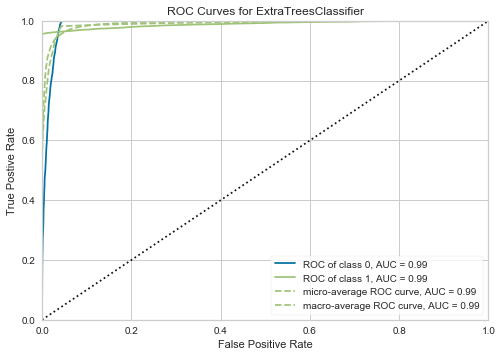

In [74]:
plot_model(et) # AUC

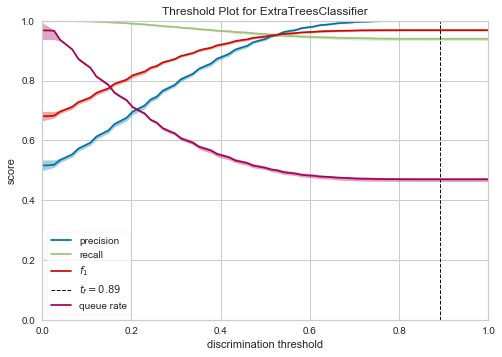

In [75]:
plot_model(et, plot='threshold')

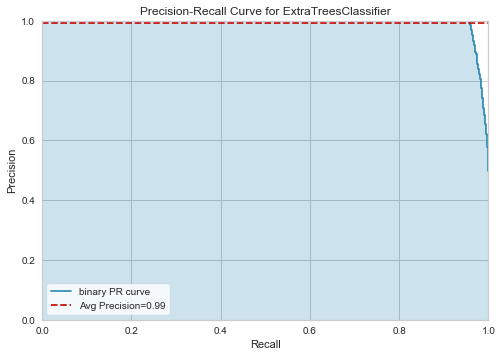

In [76]:
plot_model(et, plot='pr')

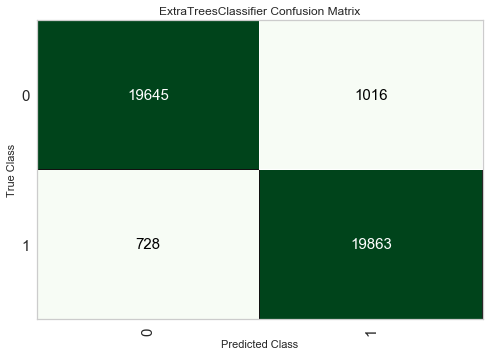

In [77]:
plot_model(et, plot='confusion_matrix')

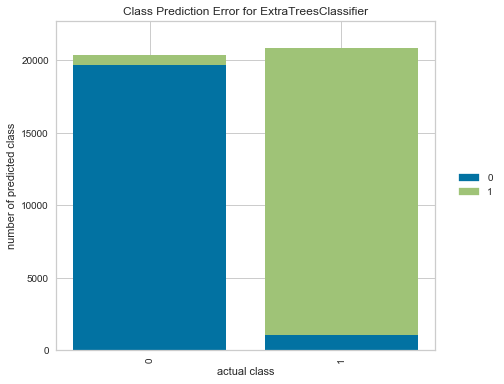

In [78]:
plot_model(et, plot='error')

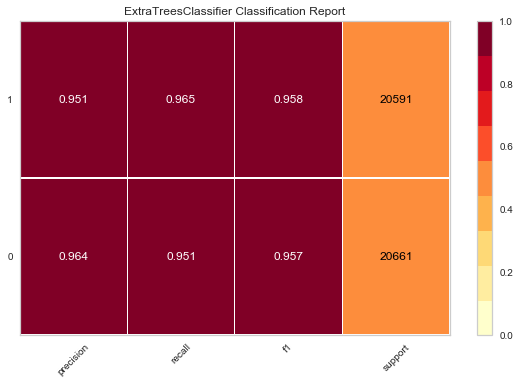

In [79]:
plot_model(et, plot='class_report')

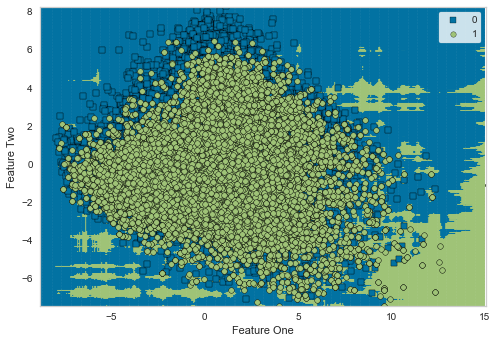

In [80]:
plot_model(et, plot='boundary')

In [81]:
#plot_model(et, plot='rfe')

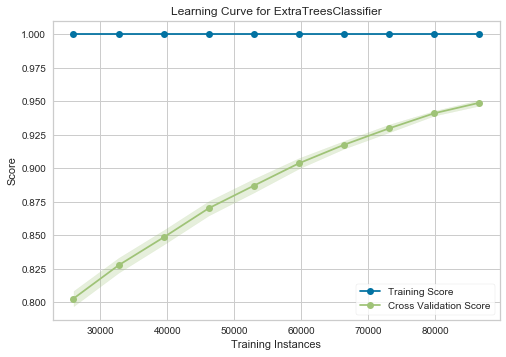

In [82]:
plot_model(et, plot='learning')

In [ ]:
plot_model(et, plot='manifold')

IntProgress(value=0, description='Processing: ', max=5)

In [ ]:
plot_model(et, plot='calibration')

In [ ]:
plot_model(et, plot='vc')

In [ ]:
plot_model(et, plot='dimension')

In [ ]:
plot_model(et, plot = 'feature')

In [ ]:
plot_model(et, plot = 'parameter')

# Interpret Models

## Extra Trees Classifier Correlation Plots

In [ ]:
interpret_model(et, plot = 'summary')

In [ ]:
interpret_model(et, plot='correlation', feature='state_Number_4.0')

In [ ]:
interpret_model(et, plot='correlation', feature='mSA')

In [ ]:
interpret_model(et, plot='correlation', feature='avgCreditScore')

In [ ]:
interpret_model(et, plot='correlation', feature='bestCreditScore')

In [ ]:
interpret_model(et, plot='correlation', feature='borrCreditScore')

In [ ]:
interpret_model(et, plot='correlation', feature='fmacRateAvg')

In [ ]:
interpret_model(et, plot='correlation', feature='origLTV_15.0')

In [ ]:
interpret_model(et, plot='correlation', feature='fedRate')

In [ ]:
interpret_model(et, plot='correlation', feature='rateDiffAvg')

In [ ]:
interpret_model(et, plot='correlation', feature='rateDiffAbovePct')

# Catboost Analysis

In [ ]:
#plot_model(catboost_bagged)

In [ ]:
#plot_model(catboost, plot='class_report')

# Interpret Catboost Model

## Catboost Summary

In [ ]:
#interpret_model(catboost, plot = 'summary')

## Catboost Correlation Plots

In [ ]:
#interpret_model(tuned_catboost, plot = 'correlation')

In [ ]:
#interpret_model(tuned_catboost, plot='correlation', feature='zipCode')

In [ ]:
#interpret_model(tuned_catboost, plot='correlation', feature='origUPB')

In [ ]:
#interpret_model(tuned_catboost, plot='correlation', feature='origDebtIncRatio')

## Predict models

In [ ]:
pred_holdout = predict_model(et)

In [ ]:
#pred_holdout2 = predict_model(catboost_bagged)

In [ ]:
#pred_holdout = predict_model(lightgbm)

In [ ]:
#pred_holdout = predict_model(xgboost)

## Finalize models

In [ ]:
final_et = finalize_model(et)

In [ ]:
#final_lightgbm = finalize_model(lightgbm)

In [ ]:
#final_xgboost = finalize_model(xgboost)

## Save model

In [ ]:
save_model(et, 'Forclo_2_Over50-50_et_052420')

In [ ]:
#save_model(lightgbm, 'Forclo_2_lightgbm_052320')

In [ ]:
#save_model(xgboost, 'Forclo_2_xgboost_052320')